# Projeto Final do Módulo de Machine Learning II
#### Descrição:
    Resolver um case para ingressar na empresa Ada & Rogério Ltda.
#### Regras:
- Tente utilizar todos os tópicos aprendidos em sala de aula.

#### Grupo composto por:
- Rayssa Vilaça
---

## Problema
<img src="https://scontent-gig4-1.xx.fbcdn.net/v/t1.6435-9/121803114_1710834379118412_3388679149178446920_n.jpg?_nc_cat=102&ccb=1-7&_nc_sid=5f2048&_nc_ohc=pqIfdz7_7P4Q7kNvgEr-HmN&_nc_ht=scontent-gig4-1.xx&oh=00_AfB5WJpyHPwHx9OWarEnirDH0GVJhv4wyv-tPu6PwKYeHQ&oe=665A6DC5" width="50%">

**Motivação**: Encontrar o momento ideal para roubar uma casa.

**Objetivo**: Predizer se um cômodo está ocupado ou desocupado com base em dados do ambiente, incluindo temperatura, umidade relativa, luminosidade e concentração de dióxido de carbono.

## Dados
Dados experimentais usados para classificação binária sobre a ocupação de um cômodo. A base de dados foi obtida através do [Kaggle](https://www.kaggle.com/datasets/sachinsharma1123/room-occupancy).

A base contém um único arquivo chamado **file.csv**. Este arquivo possui as seguintes colunas:

* **Temperature**: Temperatura em grau Celsius 
* **Humidity**: Umidade relativa em porcentagem
* **Light**: Quantidade de luz em lux
* **C02**: Concentração de dióxido de carbono em ppm
* **HumidityRatio**: Razão de humidade em kgwater-vapor/kg-air (Quantidade derivada da temperatura e humidade relativa)
* **Occupancy**: Status da ocupação

   * 1 - Há chances de que o cômodo esteja ocupado
   * 0 - Sem chances de que o cômodo esteja ocupado

### Importações

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

### Configurações iniciais

In [2]:
# Semente
RANDOM_STATE = 666

# Cores
BACKGROUND_COLOR = '#191622'
COLOR = '#868686'
BRANCO = '#fff'

# Fonte
FONT_FAMILY = 'Balto'

# Estilo pandas
plt.style.use('fivethirtyeight')

# Estilo gráficos
layout_padrao = dict(
    # Gerais
    width=1000,
    height=600,
    font=dict(
        color=BRANCO,
        family=FONT_FAMILY
    ),
    margin=dict(
        l=60,
        r=30,
        b=80,
        t=50,
    ),
    paper_bgcolor=BACKGROUND_COLOR,
    plot_bgcolor=BACKGROUND_COLOR,
    
    # Titulo
    title_font_size=20,
    title_x=0.5,
    title_xanchor='center',
    
    # Eixo X
    xaxis=dict(
        gridcolor=COLOR,
        gridwidth=1,
        zerolinecolor=COLOR,
        zerolinewidth=2,
        tickfont_size=14,
        title_font_size=16,
    ),
    
    # Eixo Y
    yaxis=dict(
        gridcolor=COLOR,
        gridwidth=1,
        zerolinecolor=COLOR,
        zerolinewidth=2,
        tickfont_size=14,
        title_font_size=16,
    )
    
)

### Funções

In [3]:
def criar_df_metricas(y_train, y_train_pred, y_test, y_test_pred):
    
    """
    Função que retorna as métricas para modelo de classificação para dados de treino e teste.

    Parâmetros:
    y_train (Series): labels de treino.
    y_train_pred (Series): labels obtidas pelo modelo ao prever utilizando X_train.
    y_test (Series): labels de teste.
    y_test_pred (Series): labels obtidas pelo modelo ao prever utilizando X_test.

    Retorna:
    Dataframe: Dataframe com as métricas para treino e teste.
    """
    
    metricas = pd.DataFrame(index=['train', 'test'])

    metricas.loc['train', 'accuracy'] = accuracy_score(y_train, y_train_pred)
    metricas.loc['train', 'precision'] = precision_score(y_train, y_train_pred)
    metricas.loc['train', 'recall'] = recall_score(y_train, y_train_pred)
    metricas.loc['train', 'f1'] = f1_score(y_train, y_train_pred)
    metricas.loc['train', 'roc_auc'] = roc_auc_score(y_train, y_train_pred)

    metricas.loc['test', 'accuracy'] = accuracy_score(y_test, y_test_pred)
    metricas.loc['test', 'precision'] = precision_score(y_test, y_test_pred)
    metricas.loc['test', 'recall'] = recall_score(y_test, y_test_pred)
    metricas.loc['test', 'f1'] = f1_score(y_test, y_test_pred)
    metricas.loc['test', 'roc_auc'] = roc_auc_score(y_test, y_test_pred)

    return metricas

### Análise do dataset

In [4]:
# Primeiramente, vamos carregar o dataset e olhar os cinco primeiros registros
ocupacao_dados = pd.read_csv("assets/file.csv")
ocupacao_dados.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


In [5]:
# Vamos verificar o tamanho do dataset através da quantidade de registros e atributos
linhas = ocupacao_dados.shape[0]
colunas = ocupacao_dados.shape[1]
print(f"O dataset possui {linhas} registros e {colunas} atributos.")

O dataset possui 2665 registros e 6 atributos.


In [6]:
# Conhecendo melhor o dataset identificando os tipos de dados de cada coluna
ocupacao_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    2665 non-null   float64
 1   Humidity       2665 non-null   float64
 2   Light          2665 non-null   float64
 3   CO2            2665 non-null   float64
 4   HumidityRatio  2665 non-null   float64
 5   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 125.0 KB


In [7]:
# Verificando se há valores nulos para serem tratados nas colunas
ocupacao_dados.isna().sum()

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [8]:
# Vamos ter uma visão geral dos dados por meio do resumo estatístico de cada coluna
ocupacao_dados.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [9]:
# Verificando a distribuição dos dados por labelb
qtd_por_ocupacao = ocupacao_dados['Occupancy'].value_counts().sort_values().reset_index()
qtd_por_ocupacao['Occupancy Label'] = qtd_por_ocupacao['Occupancy'].apply(lambda x: 'Ocupado' if x == 1 else 'Não ocupado')

fig = go.Figure(
    go.Bar(
        x=qtd_por_ocupacao['Occupancy Label'],
        y=qtd_por_ocupacao['count']
    )
)

fig.update_layout(
    title_text="Frequência por ocupação",
    yaxis_title='Quantidade de cômodos',

    # Padrao
    **layout_padrao,
    
    # Eixo X
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)

fig.show()

Podemos observar que o dataset possui mais dados para a classe *Não ocupado* ou *0*.

In [10]:
# Antes de treinar o modelo, iremos verificar a correlação entre as variáveis
corr = ocupacao_dados.corr()

fig = go.Figure(
    go.Heatmap(
        z=corr,
        x=corr.columns,
        y=corr.columns,
        colorscale='Viridis'
    )
)
fig.update_layout(
    title_text="Matriz de Correlação",

    # Padrao
    **layout_padrao,
)

fig.show()

In [11]:
"""
Com base na matriz de correlação, é evidente que a variável HumidityRatio, obtida a partir
das variáveis Temperature e Humidity, apresenta uma correlação significativa com essas variáveis.
Portanto, será excluída do conjunto de dados. 

As variáveis serão divididas em dois conjuntos, variáveis independentes representada por X e variável dependente y. 
"""

X = ocupacao_dados[['Temperature', 'Humidity', 'Light', 'CO2']]
y = ocupacao_dados['Occupancy']

In [12]:
# Após definirmos X e y, iremos dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
# Normalizar os dados
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [14]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Quais métricas utilizar?

Para este problema, acredito que os **Falsos Negativos** são mais problemáticos do que os **Falsos Positivos**. Imagine alguém que possua mesmo 
os dados de ambiente do local que pretende invadir. Se o modelo prever que o cômodo está vazio, esse indíviduo pode interpretar isso como uma oportunidade para adentrar e cometer o roubo. No entanto, se for um caso de **Falso Negativo**, ou seja, o modelo prever incorretamente que não há ninguém quando na verdade o cômodo está ocupado, o invasor corre sérios riscos de ser pego em flagrante.

Por outro lado, no caso de um **Falso Positivo**, o modelo prevê erroneamente que o cômodo está ocupado quando na verdade não está. Isso significa que o indivíduo deixou uma ótima oportunidade passar. Entretanto, quando se trata de escolher entre perder uma oportunidade ou os dentes, é preferível o primeiro. Portanto, o recall é uma métrica 
interessante de ser utilizada, uma vez que avalia o erro do **tipo II**, ou seja, a quantidade de **Falsos Negativos**
identificados pelo modelo.

<img src="jerome.gif" width="600px">



### SVC

In [15]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc.fit(X_train, y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print(criar_df_metricas(y_train, y_train_pred, y_test, y_test_pred))

       accuracy  precision    recall        f1   roc_auc
train  0.979362   0.947879  0.998723  0.972637  0.983424
test   0.977486   0.944724  0.994709  0.969072  0.981366


In [16]:
matriz_confusao = confusion_matrix(y_test, y_test_pred)

fig = go.Figure(
    go.Heatmap(
        z=matriz_confusao,
        text=matriz_confusao,
        texttemplate="%{text}",
        textfont={"size":20},
        x=['False', 'True'],
        y=['False', 'True'],
        colorscale='Viridis'
    )
)
fig.update_layout(
    title_text="Matriz de Confusão",
    xaxis_title='Predicted label',
    yaxis_title='True label',
    # Padrao
    **layout_padrao,
)

fig.show()

### Ensembles (GradientBoostingClassifier)

In [17]:
gbc = GradientBoostingClassifier(
    learning_rate = 0.1, 
    n_estimators = 100,
    max_depth = 3,
    random_state=RANDOM_STATE
)

gbc.fit(X_train, y_train)

y_train_pred = gbc.predict(X_train)
y_test_pred = gbc.predict(X_test)

print(criar_df_metricas(y_train, y_train_pred, y_test, y_test_pred))

       accuracy  precision    recall        f1   roc_auc
train  0.998593   0.996183  1.000000  0.998088  0.998888
test   0.986867   0.973958  0.989418  0.981627  0.987442


In [18]:
matriz_confusao = confusion_matrix(y_test, y_test_pred)

fig = go.Figure(
    go.Heatmap(
        z=matriz_confusao,
        text=matriz_confusao,
        texttemplate="%{text}",
        textfont={"size":20},
        x=['False', 'True'],
        y=['False', 'True'],
        colorscale='Viridis'
    )
)
fig.update_layout(
    title_text="Matriz de Confusão",
    xaxis_title='Predicted label',
    yaxis_title='True label',
    # Padrao
    **layout_padrao,
)

fig.show()

### Ensembles (GradientBoostingClassifier com hiperparâmetros otimizados)

In [19]:
# Selecionando os parâmetros que serão testados
parametros = {
  'learning_rate': [0.1, 0.2, 0.3], 
  'n_estimators': [100, 200],
  'max_depth': [2, 3, 6],
}

# Configurando a busca para o classificador KNN utilizando os parâmetros selecionados
random_search = RandomizedSearchCV(
  estimator=GradientBoostingClassifier(),
  param_distributions=parametros,
  n_iter=200,
  cv=5,
  random_state=RANDOM_STATE
)

# Ajustando a pesquisa aleatória ao conjunto de treinamento
random_search.fit(X_train, y_train)

# obtendo os melhores parâmetros
gbc_melhores_parametros = random_search.best_params_
print(gbc_melhores_parametros)

{'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2}


In [20]:
# Instanciando um novo classificador KNN configurado com os melhores parâmetros
gbc_parametros_otimizados = GradientBoostingClassifier(**gbc_melhores_parametros)

# Treinar o modelo
gbc_parametros_otimizados.fit(X_train, y_train)

# Prever as classes utilizando o X de treino
y_train_pred = gbc_parametros_otimizados.predict(X_train)

# Prever as classes utilizando o X de teste
y_test_pred = gbc_parametros_otimizados.predict(X_test)

# Obtendo as principais métricas de desempenho para o classificador
print(criar_df_metricas(y_train, y_train_pred, y_test, y_test_pred))

       accuracy  precision    recall       f1  roc_auc
train  1.000000   1.000000  1.000000  1.00000  1.00000
test   0.986867   0.978947  0.984127  0.98153  0.98625


In [21]:
matriz_confusao = confusion_matrix(y_test, y_test_pred)

fig = go.Figure(
    go.Heatmap(
        z=matriz_confusao,
        text=matriz_confusao,
        texttemplate="%{text}",
        textfont={"size":20},
        x=['False', 'True'],
        y=['False', 'True'],
        colorscale='Viridis'
    )
)
fig.update_layout(
    title_text="Matriz de Confusão",
    xaxis_title='Predicted label',
    yaxis_title='True label',
    # Padrao
    **layout_padrao,
)

fig.show()

### Não-supervisionado (KMeans)

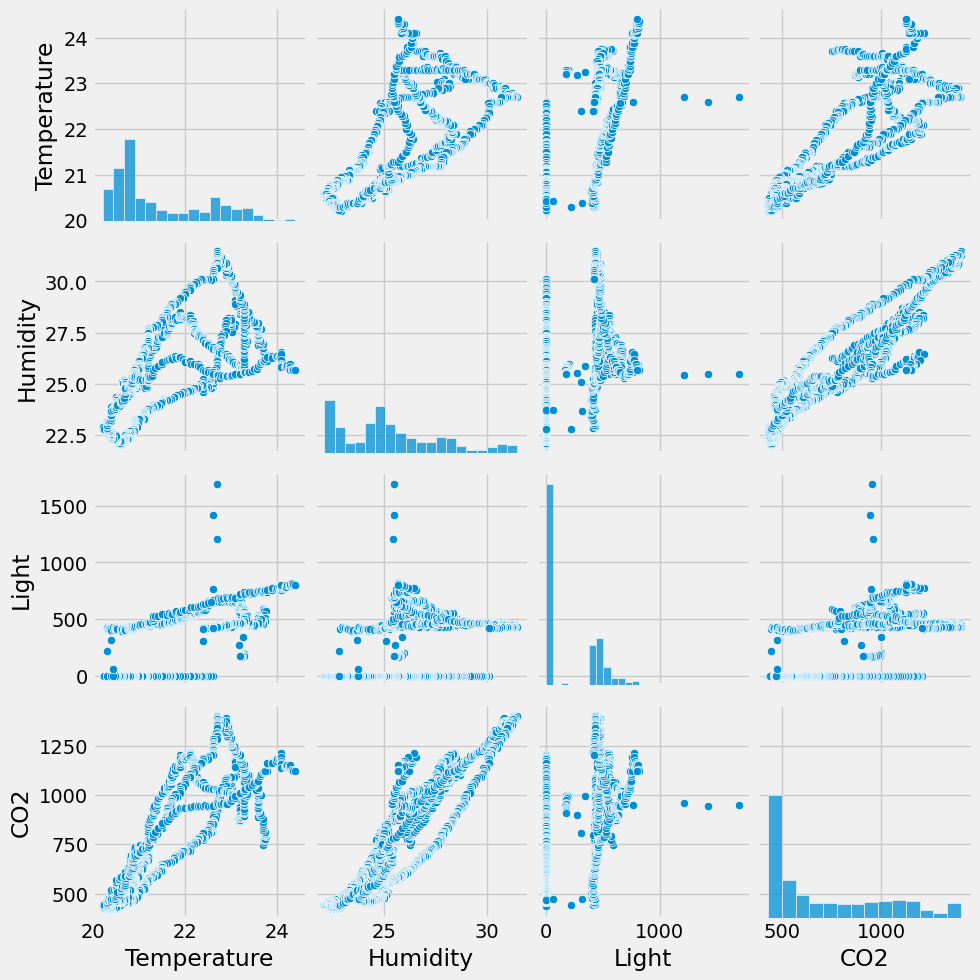

In [22]:
sns.pairplot(data=X)

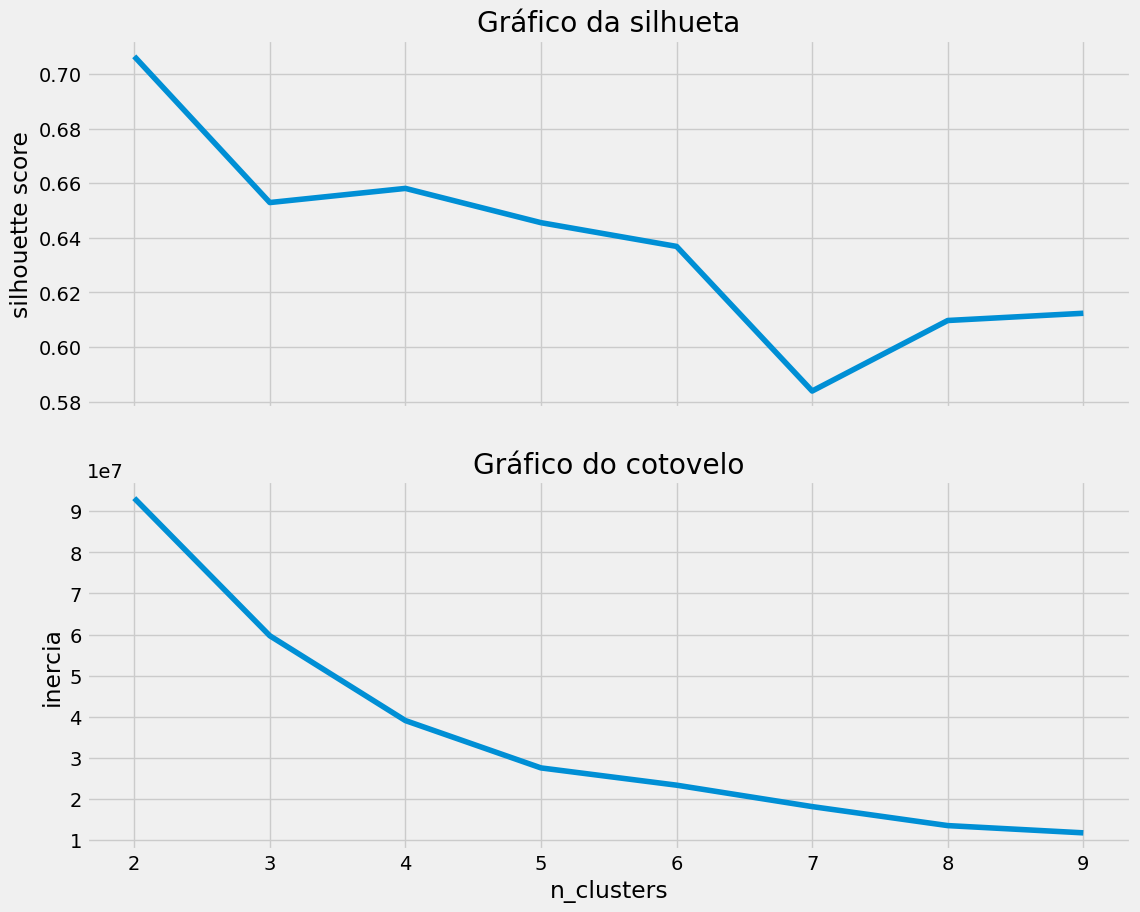

In [23]:
wcss = []
silhuetas = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X)

    silhueta = silhouette_score(X, kmeans.labels_)
    silhuetas.append(silhueta)
    wcss.append(kmeans.inertia_)
    
fig, ax = plt.subplots(2, 1,figsize = (12,10), sharex = True)
ax[0].plot(range(2, 10), silhuetas)
ax[0].set_ylabel("silhouette score")
ax[0].set_title("Gráfico da silhueta")

ax[1].plot(range(2, 10), wcss)
ax[1].set_xlabel("n_clusters")
ax[1].set_ylabel("inercia")
ax[1].set_title("Gráfico do cotovelo")
plt.show()

In [24]:
""" 
Como observado no gráfico de silhueta, o número de clusters que obtem o valor de silhouette score mais próximo a 1 é o 2. Logo,
itemos utilizar n_clusters = 2 ao instanciar o modelo KMeans.
"""
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)

In [25]:
kmeans.fit(X)

KMeans(n_clusters=2, random_state=666)

In [26]:
X["labels"] = kmeans.labels_

In [27]:
X["labels"].value_counts()

labels
0    1664
1    1001
Name: count, dtype: int64